In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
print(device)

cpu


In [3]:
print(device)

cpu


In [4]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [5]:
data_df = pd.read_csv("all_data_lake_modeling_in_time_wHeat.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,buoyancy,diffusivity,temp_heat00,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp,input_obs
0,1,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.467275,11.467275,155,1,11.545011,11.570472,16.409,16.350
1,2,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.650008,11.627332,155,1,11.545011,11.570472,16.480,16.426
2,3,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000271,0.000021,11.650008,11.631393,155,1,11.631393,11.575860,16.130,16.088
3,4,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000278,0.000021,11.394500,11.393058,155,1,11.393058,11.393058,15.827,15.789
4,5,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000185,0.000024,11.123803,11.130929,155,1,11.130929,11.130929,16.270,16.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35370,21,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000282,0.000020,6.772435,6.773650,213,23,6.773650,6.773650,12.204,12.204
35371,22,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000191,0.000024,5.995879,5.996763,213,23,5.996763,5.996763,12.204,12.204
35372,23,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000102,0.000032,5.229508,5.230045,213,23,5.230045,5.230045,12.204,12.204
35373,24,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000013,0.000037,4.467800,4.468109,213,23,4.468109,4.468109,12.204,12.204


In [6]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 1415
Number of training points: 21225


# Normalizing Data

In [7]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [8]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'temp_heat00', 'diffusivity']
output_columns = ['temp_diff01']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [9]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (21225, 15), X_test: (14150, 15)
y_train: (21225, 1), y_test: (14150, 1)


In [10]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [11]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [12]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [13]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [14]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=15, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [19]:
def implicit_diffusion(diff, temp, mean, std, mean2, std2):
    
    #mean = torch.tensor(mean).to(device)
    # std = torch.tensor(std).to(device)
    mean_diff = torch.tensor(mean[input_column_ix[13]]).to(device)
    std_diff = torch.tensor(std[input_column_ix[13]]).to(device)
    
    mean_temp = torch.tensor(mean[input_column_ix[14]]).to(device)
    std_temp = torch.tensor(std[input_column_ix[14]]).to(device)
    
    mean_out = torch.tensor(mean2).to(device)
    std_out = torch.tensor(std2).to(device)
    
    # de-normalise data
    diff = diff * std_diff + mean_diff
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    
    #print(t)
    
    dt = 3600 # model time step - fixed
    dx = 1 # model space step - fixed

    # OUTPUT FROM MLP
    d = diff #np.array([1e-5] * len(t)) # estimated diffusivity values

    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
    j = len(t)
#     y = torch.zeros((len(t), len(t)))

    alpha = (dt/dx**2) * d    
    az = alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = -alpha # superdiagonal
    bz[0] = 1
    az[len(az)-2] = 0
    bz[len(bz)-1] = 1
    cz[0] = 0
    
    y = torch.diag(bz[:, 0])+torch.diag(az[:-1, 0],-1)+torch.diag(cz[:-1, 0],1) #slightly efficient way of computing the diagonal matrices
    y[j-1, j-1] = 1
    
#     # tridiagonal matrix
#     for k in range(j-1):
#         y[k][k] = bz[k]
#         y[k][k+1] = cz[k]
#         y[k+1][k] = az[k]

    

    mn = torch.zeros_like(t)    
    mn[0] = t[0]
    mn[1:j-1] = alpha[1:j-1,0]*t[:j-2] + 2 * (1 - alpha[1:j-1,0])*t[1:j-1] + alpha[1:j-1,0]*t[1:j-1] #is be same as the loop
    mn[len(mn)-1] = t[len(t)-1]

#     for k in range(1,j-1):
#         mn[k] = alpha[k] * t[k-1] + 2 * (1 - alpha[k]) * t[k] + alpha[k] * t[k]

    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    output = torch.linalg.solve(y, mn)
    
    proj = output
    
    # scaler = StandardScaler()
    # scaler.fit(proj.reshape(-1, 1))
    # scaler.fit(proj)
    
    # normalise data back
    #proj = scaler.transform(proj.reshape(-1, 1))
    # proj = scaler.transform(proj)
    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out
    proj = proj.to(torch.double)

#     proj = proj.float()

    
    return proj

In [20]:
# j= 5
# alpha = torch.tensor([1.,2.,3.,4.,5.])
# y = torch.zeros(5, 5)
# az = alpha # subdiagonal
# bz = 2 * (1 + alpha) # diagonal
# cz = -alpha # superdiagonal

# bz[0] = 1
# az[len(az)-2] = 0
# bz[len(bz)-1] = 1
# cz[0] = 0

# # tridiagonal matrix
# for k in range(j-1):
#     y[k][k] = bz[k]
#     y[k][k+1] = cz[k]
#     y[k+1][k] = az[k]

# y[j-1, j-1] = 1

In [21]:
print(input_column_ix)
print(input_mean)
print(input_mean[input_column_ix[13]])
print(output_mean)
#print(torch.tensor(input_mean[input_column_ix][14]).to(device))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 14, 13]
[ 1.30000000e+01  1.93619387e+01  7.97611281e+02 -1.27637027e+02
 -1.68297160e+01  2.36993670e+02  4.08006076e-01  2.30560213e+00
  8.82174601e-03  3.60000000e+07  8.40535870e-04  1.72232038e+02
  1.14310954e+01  1.13445025e+01  2.07829505e-05]
2.0782950512289867e-05
[11.34604205]


In [24]:
# # test if the Crank-Nicholson scheme works

temp = torch.rand(5,1)
diff = torch.rand(5,1)
print(temp), print(diff)
implicit_diffusion(diff, temp, input_mean, input_std,
                                 output_mean, output_std)

tensor([[0.4518],
        [0.2216],
        [0.1746],
        [0.4633],
        [0.2058]])
tensor([[0.0609],
        [0.8790],
        [0.2596],
        [0.8389],
        [0.0378]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])


RuntimeError: The expanded size of the tensor (1) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [3, 1].  Tensor sizes: [3, 3]

In [23]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        
        # get temperature input
        temp_input = x[:,13]
        #print(temp_input)
        
        
        optimizer.zero_grad()
        #print(model(x))
        proj = model(x)
        
        #print(proj)
        
        # torch.set_printoptions(profile="full")
        
        pred = implicit_diffusion(proj, temp_input, input_mean, input_std,
                                 output_mean, output_std)

        # print(pred)
        # print(y)
        
        #pred.grad.data.copy_(proj.grad.data)
        
        # proj[0:30,0] = pred
        
        # print(proj)
        
        #print(pred)
        #print(y)
        
        pred = pred.to(dtype=torch.float32)
        
        loss = criterion(pred, y)
        #print(loss)
        #loss= loss.double
        #print(loss)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            #pred = model(x)
            
            #mean=0.0
            #std=1.0
            #mean = torch.tensor(mean).to(device)
            #std = torch.tensor(std).to(device)
            temp_input = x[:,13] #* std + mean

            optimizer.zero_grad()
            proj = model(x)

            pred = implicit_diffusion(proj, temp_input, input_mean, input_std,
                                 output_mean, output_std)

            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[-0.2699],
        [ 0.2206],
        [-0.2203],
        ...,
        [-0.6242],
        [ 0.0595],
        [-0.2288]], grad_fn=<AddmmBackward0>)
tensor([ 0.0826, -0.6821,  2.0736,  ..., -1.1207, -1.0948, -0.9381])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.3982],
        [-0.2148],
        [ 0.1911],
        ...,
        [-0.1199],
        [-0.4668],
        [-0.0048]], grad_fn=<AddmmBackward0>)
tensor([-0.2526,  2.0713,  1.0556,  ..., -0.8050, -0.1898, -1.0798])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.2033],
        [-0.2385],
        [-0.0662],
        ...,
        [ 0.1403],
        [ 0.0644],
        [-0.1885]], grad_fn=<AddmmBackward0>)
tensor([-0.1410,  0.3852, -0.0044,  ..., -1.1938, -0.5262, -0.9371])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.2943],
        [ 0.3364],
        [-0.5885],
        ...,
        [-0.1544],
        [-0.1789],
        [ 0.0847]], grad_fn=<AddmmBackward0>)
tensor([-1.2885, -0.9203,  0.1634,  ..., -0.0689, -0.0392,  

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])


  0%|          | 1/1000 [00:01<27:36,  1.66s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

  0%|          | 2/1000 [00:02<22:18,  1.34s/it]

tensor([[ 4.1798e-01],
        [ 5.5752e-01],
        [ 1.3047e+00],
        [ 1.2870e+00],
        [ 5.9222e-01],
        [ 8.4123e-01],
        [ 6.3250e-01],
        [ 5.0586e-01],
        [ 1.1363e+00],
        [ 3.3268e-01],
        [ 1.3268e+00],
        [ 5.2032e-01],
        [ 2.0625e+00],
        [ 2.0716e+00],
        [ 3.5645e-01],
        [ 4.5250e+00],
        [ 8.7809e-01],
        [ 8.6917e-01],
        [ 1.9255e+00],
        [ 8.5842e-01],
        [ 1.0611e+00],
        [ 1.9214e+00],
        [ 2.9384e+00],
        [ 5.2153e-01],
        [ 2.1853e+00],
        [ 8.2068e-01],
        [ 2.1592e-01],
        [ 8.6310e-01],
        [ 4.7126e-01],
        [ 5.7275e-01],
        [ 3.4269e+00],
        [ 1.0874e+00],
        [ 1.9199e+00],
        [ 2.6207e-01],
        [ 8.7491e-01],
        [ 4.1214e+00],
        [ 5.3268e-01],
        [ 2.5111e-01],
        [ 3.9116e-01],
        [ 2.8629e+00],
        [ 1.2931e+00],
        [ 1.0628e+00],
        [ 1.9381e+00],
        [ 1

tensor([[1.0978],
        [0.0611],
        [0.7837],
        ...,
        [3.7235],
        [1.3860],
        [1.6830]], grad_fn=<AddmmBackward0>)
tensor([ 0.2806, -0.7771, -0.0328,  ...,  1.7528, -0.4877,  0.0464])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[1.0396],
        [1.5694],
        [0.7483],
        ...,
        [2.7886],
        [2.2967],
        [0.4543]], grad_fn=<AddmmBackward0>)
tensor([ 0.0257, -0.0887, -1.0528,  ..., -0.0581,  0.3246, -0.9966])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[0.6490],
        [0.1961],
        [1.2118],
        ...,
        [3.3744],
        [3.3456],
        [0.5598]], grad_fn=<AddmmBackward0>)
tensor([-0.9459, -1.2974, -0.0478,  ..., -0.0468, -0.1902, -0.7942])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[1.0860],
        [2.1818],
        [1.0867],
        ...,
        [1.1726],
        [2.1943],
        [3.9906]], grad_fn=<AddmmBackward0>)
tensor([-0.4763, -1.2884, -0.5075,  ...,  0.0124, -0.9869,  2.0457])
tensor([0., 0.,

  0%|          | 3/1000 [00:03<20:25,  1.23s/it]

tensor([[0.2231],
        [3.1200],
        [4.1321],
        ...,
        [2.5775],
        [3.6304],
        [7.7937]], grad_fn=<AddmmBackward0>)
tensor([-0.8863,  0.8227,  1.8279,  ..., -1.0134,  1.4952,  2.5299])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 7.0472e-01],
        [ 4.3763e-01],
        [ 1.2350e+00],
        [-4.3552e-02],
        [ 3.7102e-01],
        [ 5.3251e-01],
        [ 4.1864e-01],
        [ 6.9600e+00],
        [ 5.6400e-01],
        [ 9.0348e+00],
        [ 3.2607e+00],
        [ 1.7129e+00],
        [ 4.0954e-01],
        [ 7.2387e-01],
        [ 1.0282e+00],
        [ 1.7537e+00],
        [ 1.9786e+00],
        [ 7.7379e+00],
        [ 1.5403e+00],
        [ 2.1637e+00],
        [ 2.0284e-01],
        [ 3.2094e+00],
        [ 1.4317e+00],
        [ 3.4035e-01],
        [ 1.1100e+00],
        [ 1.4557e+00],
        [ 1.0892e+00],
        [ 1.2268e+00],
        [ 7.1406e-01],
        [ 2.0722e+00],
        [ 3.1980e+00],
        [ 3.7100e-01],
        

tensor([[ 0.3450],
        [ 1.3750],
        [ 4.6650],
        ...,
        [10.5701],
        [ 3.4380],
        [ 1.3195]], grad_fn=<AddmmBackward0>)
tensor([-1.2311,  0.5973,  1.4027,  ...,  2.3623,  0.4659, -0.5920])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[2.8758],
        [4.9741],
        [2.1335],
        ...,
        [1.7721],
        [6.0860],
        [8.2826]], grad_fn=<AddmmBackward0>)
tensor([-0.8880, -0.0803,  0.7337,  ..., -1.2894,  1.3616,  1.8201])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[1.6336],
        [0.7818],
        [0.9435],
        ...,
        [0.1038],
        [2.8169],
        [0.5140]], grad_fn=<AddmmBackward0>)
tensor([-1.1941, -1.0373, -0.9612,  ..., -0.4932, -0.9311, -0.2354])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[1.7356],
        [1.6805],
        [1.6208],
        ...,
        [0.4050],
        [0.2634],
        [0.8076]], grad_fn=<AddmmBackward0>)
tensor([-1.1141,  0.0382, -1.0910,  ...,  0.1024, -0.7311,  0.2789])
tensor([0

  0%|          | 4/1000 [00:04<18:53,  1.14s/it]

tensor([[2.4097],
        [4.2744],
        [6.4645],
        ...,
        [1.1368],
        [1.5031],
        [0.7667]], grad_fn=<AddmmBackward0>)
tensor([ 0.9213, -0.9277,  0.9484,  ..., -1.2902, -1.1012,  0.4411])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[7.6567],
        [5.0183],
        [7.4721],
        ...,
        [4.2767],
        [0.8020],
        [0.8778]], grad_fn=<AddmmBackward0>)
tensor([ 0.5151,  0.3875,  1.1491,  ..., -0.9243, -1.2961, -0.0022])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 5.5443e+00],
        [ 2.7006e+00],
        [ 3.2314e+00],
        [ 2.1228e+00],
        [ 1.1642e+01],
        [ 1.1740e+00],
        [ 4.1158e-01],
        [ 9.3734e-01],
        [ 1.4545e+00],
        [ 3.3252e+00],
        [ 2.2304e+00],
        [ 6.8496e+00],
        [ 1.2604e+00],
        [ 1.9254e+00],
        [ 3.2176e+00],
        [ 1.8956e+00],
        [-1.2851e-01],
        [ 1.2332e-01],
        [ 9.7848e-01],
        [ 3.1461e+00],
        [ 9.9012e+00],
     

tensor([[1.3992],
        [4.0388],
        [1.2600],
        ...,
        [2.3412],
        [3.8744],
        [0.4406]], grad_fn=<AddmmBackward0>)
tensor([-0.2431,  0.4474,  0.4875,  ...,  0.2185, -1.1915, -0.6873])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[4.5371],
        [2.0021],
        [3.1862],
        ...,
        [1.0911],
        [1.4523],
        [1.6448]], grad_fn=<AddmmBackward0>)
tensor([-0.8356, -0.9952,  0.9226,  ...,  0.3560,  0.1243, -1.2165])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 0.1825],
        [ 1.7801],
        [ 1.8202],
        ...,
        [ 1.6601],
        [ 3.7136],
        [18.1884]], grad_fn=<AddmmBackward0>)
tensor([-0.2462,  0.1709, -0.9459,  ..., -1.0660, -1.2885,  2.4335])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 1.5600],
        [-0.1052],
        [ 0.7274],
        ...,
        [ 2.4045],
        [ 1.6617],
        [ 0.1681]], grad_fn=<AddmmBackward0>)
tensor([-0.9720, -0.1332,  0.2524,  ...,  0.9179, -0.4367, -0.5641])
ten

  0%|          | 5/1000 [00:06<19:41,  1.19s/it]

tensor([[ 5.2899e-01],
        [ 5.6358e+00],
        [ 3.8625e+00],
        [ 7.4379e+00],
        [ 6.2944e+00],
        [ 2.3806e+00],
        [ 2.2558e+00],
        [ 9.0950e-01],
        [ 3.7386e+00],
        [ 2.3589e-02],
        [ 2.9280e+00],
        [ 5.2157e-01],
        [ 9.6339e+00],
        [ 4.7449e+00],
        [ 3.4889e+00],
        [ 3.7846e+00],
        [ 4.7294e+00],
        [ 1.6178e+00],
        [ 1.1493e+01],
        [ 1.1059e+01],
        [ 4.1696e+00],
        [ 1.2428e+00],
        [ 6.5383e-01],
        [ 5.3096e+00],
        [ 2.7556e-01],
        [ 8.0342e-01],
        [ 1.8430e+00],
        [ 8.0284e+00],
        [ 4.0630e+00],
        [ 1.1627e+00],
        [ 9.6226e+00],
        [ 5.0495e+00],
        [ 1.3575e+00],
        [ 1.7733e+00],
        [ 1.0082e+01],
        [ 1.7717e+00],
        [ 3.6993e+00],
        [ 2.6539e-04],
        [ 5.5899e+00],
        [ 8.9042e+00],
        [-4.0200e-01],
        [ 2.4188e+00],
        [ 4.4733e+00],
        [ 1

tensor([[11.5270],
        [22.4575],
        [ 1.3204],
        ...,
        [ 5.3102],
        [ 0.5863],
        [ 2.6848]], grad_fn=<AddmmBackward0>)
tensor([ 1.2766,  3.9650,  0.5884,  ..., -0.5461, -0.1913, -0.2550])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 2.0491],
        [ 6.9108],
        [ 5.3044],
        ...,
        [11.5027],
        [ 0.9939],
        [ 4.9545]], grad_fn=<AddmmBackward0>)
tensor([ 0.4772,  0.9785,  1.2670,  ...,  1.2692, -0.2428,  0.4169])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 2.9649],
        [ 2.9666],
        [ 2.1028],
        ...,
        [ 0.9606],
        [-0.6737],
        [ 0.9971]], grad_fn=<AddmmBackward0>)
tensor([-1.0598, -1.1254, -1.2076,  ..., -0.0251, -0.4933,  0.3491])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 2.4604],
        [ 1.3968],
        [ 0.5561],
        ...,
        [ 3.0213],
        [12.1057],
        [-0.0216]], grad_fn=<AddmmBackward0>)
tensor([-0.9004,  0.5773, -0.8786,  ..., -0.0228,  1.4592, -

  1%|          | 6/1000 [00:07<18:47,  1.13s/it]

tensor([[ 1.3461],
        [13.0589],
        [-0.0729],
        ...,
        [ 1.3729],
        [ 2.7703],
        [ 0.7255]], grad_fn=<AddmmBackward0>)
tensor([ 0.1513,  1.6967, -0.7241,  ..., -0.8246, -0.4074, -0.9655])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 2.8376e+00],
        [ 1.3930e+01],
        [ 7.8528e+00],
        [ 8.3342e+00],
        [ 3.1751e+00],
        [ 2.8953e+00],
        [ 1.1383e+01],
        [ 2.2992e+00],
        [ 5.3726e+00],
        [-1.9087e-01],
        [ 1.3439e-01],
        [ 1.1575e+00],
        [ 1.2803e+00],
        [ 1.7680e+01],
        [ 1.9004e+00],
        [ 1.1255e+01],
        [ 5.7175e-01],
        [ 1.2651e+00],
        [ 1.5637e+00],
        [ 2.0355e+00],
        [ 6.6596e-01],
        [ 8.4883e-01],
        [ 4.8733e+00],
        [ 8.1150e+00],
        [ 2.6031e+00],
        [ 9.4646e+00],
        [ 1.8164e+00],
        [ 1.3511e+00],
        [ 5.2274e+00],
        [ 3.0586e+00],
        [ 9.3713e+00],
        [ 4.6422e+00],
  

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[2.5469],
        [4.8443],
        [5.7670],
        ...,
        [1.8437],
        [2.1634],
        [3.4585]], grad_fn=<AddmmBackward0>)
tensor([ 0.3955, -1.1963,  0.4735,  ..., -1.2967, -0.9153, -1.1205])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[2.7450],
        [2.2204],
        [1.1298],
        ...,
        [2.0487],
        [1.9207],
        [1.6438]], grad_fn=<AddmmBackward0>)
tensor([-1.1223, -0.2543, -0.1448,  ..., -0.5676, -1.2959, -1.1588])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 0.6315],
        [ 7.3012],
        [ 0.7155],
        ...,
        [-0.1152],
        [ 1.7417],
        [ 0.9555]], grad_fn=<AddmmBackward0>)
tensor([-0.8607,  1.4501, -0.2902,  ..., -0.5371,  0.2541,  0.3694])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[14.7384],
        [10.3529],
        [-0.2889],
        ...,
        [ 2.1188],
        [ 8.5302],
        [ 0.2791]], grad_fn=<AddmmBackward0>)
tensor([ 2.4008,  1.4675, -0.0166

  1%|          | 7/1000 [00:08<18:24,  1.11s/it]

tensor([[ 1.1399e+00],
        [ 3.2122e+00],
        [ 8.2127e-01],
        [ 2.6162e+00],
        [ 1.0622e+01],
        [ 1.0442e+00],
        [ 3.4629e+00],
        [ 1.4472e+00],
        [-5.0127e-01],
        [ 9.2036e-01],
        [ 3.1920e+00],
        [ 3.4289e+00],
        [-8.5050e-01],
        [ 1.0735e+01],
        [ 6.4549e+00],
        [ 3.5354e+00],
        [ 4.8109e-02],
        [ 1.6899e+00],
        [ 1.1555e+01],
        [ 6.8463e-01],
        [ 3.2746e+00],
        [ 2.5529e+00],
        [ 2.7273e+00],
        [ 8.9174e-01],
        [ 8.5300e-01],
        [ 1.0996e+00],
        [-3.0896e-01],
        [ 3.3137e+00],
        [ 2.2998e+00],
        [ 3.9124e+00],
        [ 2.5206e+00],
        [ 3.2102e+00],
        [ 2.7719e+00],
        [-1.8048e+00],
        [ 4.6085e+00],
        [ 5.5029e+00],
        [ 1.1465e+01],
        [ 5.1521e+00],
        [ 8.2445e+00],
        [ 1.7480e+00],
        [ 1.1945e+00],
        [ 2.6478e+00],
        [ 1.1402e+00],
        [ 1

tensor([[3.1498],
        [1.9169],
        [1.3032],
        ...,
        [4.8409],
        [2.3745],
        [1.6883]], grad_fn=<AddmmBackward0>)
tensor([-0.7799, -0.7014,  0.2718,  ..., -0.9966,  0.3314, -0.4065])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 0.1213],
        [ 0.5854],
        [ 0.7610],
        ...,
        [ 1.8730],
        [-0.0926],
        [ 2.4407]], grad_fn=<AddmmBackward0>)
tensor([ 0.0996,  0.0373,  0.3938,  ..., -0.7056, -0.5267,  0.0455])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 1.8004],
        [ 0.5451],
        [-0.1802],
        ...,
        [ 3.5601],
        [ 1.8886],
        [12.1517]], grad_fn=<AddmmBackward0>)
tensor([-0.7043,  0.6046, -0.6937,  ..., -1.0901, -0.2346,  1.9178])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 3.1240],
        [-1.2536],
        [12.5736],
        ...,
        [ 3.8421],
        [ 3.3748],
        [ 3.0785]], grad_fn=<AddmmBackward0>)
tensor([-0.9233, -0.4530,  2.1688,  ..., -0.2116, -0.2582, -1.2977

  1%|          | 8/1000 [00:09<17:52,  1.08s/it]

tensor([[16.9477],
        [ 1.3023],
        [ 4.1130],
        ...,
        [ 1.9172],
        [ 1.1948],
        [-0.6770]], grad_fn=<AddmmBackward0>)
tensor([ 2.4264, -0.2281,  1.3415,  ...,  0.1738,  0.2460, -0.4308])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[21.5890],
        [ 4.3304],
        [ 1.8913],
        ...,
        [ 5.1280],
        [ 5.4086],
        [ 2.3472]], grad_fn=<AddmmBackward0>)
tensor([ 2.9269, -1.2285,  0.1585,  ..., -0.9734, -0.4207,  0.6134])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 3.9970e-01],
        [-8.2436e-02],
        [ 2.7950e+00],
        [ 6.2292e+00],
        [ 6.3336e+00],
        [ 4.7969e+00],
        [ 9.2122e+00],
        [ 8.6984e+00],
        [ 2.0368e+00],
        [ 1.8432e+00],
        [ 9.9394e+00],
        [ 7.2511e+00],
        [ 3.6219e+00],
        [ 5.8659e+00],
        [ 8.6770e+00],
        [ 6.8934e+00],
        [ 2.3981e+00],
        [-1.8689e+00],
        [-4.2059e-02],
        [ 6.0493e+00],
        [ 4.6685

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[0.0297],
        [8.9719],
        [6.6110],
        ...,
        [6.2942],
        [4.0571],
        [1.5103]], grad_fn=<AddmmBackward0>)
tensor([ 0.3377,  1.7530,  0.5403,  ...,  1.3160, -0.7847, -0.8105])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[15.9062],
        [10.9843],
        [ 5.9652],
        ...,
        [ 2.9513],
        [-1.0229],
        [ 2.8973]], grad_fn=<AddmmBackward0>)
tensor([ 3.0172,  1.4069, -1.2946,  ..., -0.2582, -0.4763, -0.9110])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[5.0380],
        [1.5643],
        [0.1144],
        ...,
        [6.6820],
        [6.6983],
        [0.5084]], grad_fn=<AddmmBackward0>)
tensor([-0.0737, -0.2353, -0.3195,  ..., -1.1141, -1.1938,  0.3295])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 4.6436],
        [13.0012],
        [ 0.1779],
        ...,
        [10.3655],
        [13.1774],
        [-1.4599]], grad_fn=<AddmmBackward0>)
tensor([ 0.9744,  1.9166, -0.8081

  1%|          | 9/1000 [00:10<17:37,  1.07s/it]

tensor([[ 2.8635],
        [ 7.0716],
        [ 2.3172],
        ...,
        [ 2.5656],
        [-1.4420],
        [ 1.2230]], grad_fn=<AddmmBackward0>)
tensor([-0.6616, -1.2963,  0.0441,  ...,  0.2691, -0.4574,  0.2206])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 3.5356e-01],
        [ 2.7698e+00],
        [ 3.5662e+00],
        [ 1.2991e+00],
        [ 3.6008e+00],
        [ 4.6313e+00],
        [ 7.5727e+00],
        [ 1.0793e+01],
        [ 4.3932e+00],
        [ 1.4958e+01],
        [ 5.6255e+00],
        [ 1.3658e+01],
        [ 7.9071e+00],
        [-7.3068e-01],
        [-1.0077e+00],
        [ 8.4857e+00],
        [ 3.8288e+00],
        [ 2.1421e+00],
        [ 6.5906e-01],
        [ 6.9229e+00],
        [ 9.3903e+00],
        [ 8.8468e-01],
        [ 8.0281e+00],
        [ 2.1474e+00],
        [ 4.4697e+00],
        [ 2.0447e+00],
        [ 3.3003e-01],
        [ 1.2140e+00],
        [ 1.8692e+00],
        [-2.1954e+00],
        [ 7.8993e+00],
        [-2.7222e-01],
  

tensor([[ 3.0576],
        [ 1.7153],
        [-2.7512],
        ...,
        [ 6.1133],
        [ 7.9014],
        [-0.3759]], grad_fn=<AddmmBackward0>)
tensor([ 0.1247,  0.4407, -0.0162,  ..., -1.0805, -1.2891,  0.2439])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.0105],
        [ 2.1789],
        [-1.2767],
        ...,
        [ 1.1941],
        [-0.2202],
        [-0.6179]], grad_fn=<AddmmBackward0>)
tensor([ 0.1898, -0.5972, -0.4659,  ..., -0.0581, -0.6937, -0.5553])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 7.8199],
        [-0.7170],
        [ 0.8738],
        ...,
        [ 6.0885],
        [ 0.1072],
        [ 3.5117]], grad_fn=<AddmmBackward0>)
tensor([ 0.9054,  0.4090, -0.1997,  ...,  0.7899,  0.0143, -0.9449])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 6.6472],
        [-1.9935],
        [-0.9341],
        ...,
        [ 2.1508],
        [ 0.9680],
        [24.8995]], grad_fn=<AddmmBackward0>)
tensor([-1.2070, -0.5148, -0.0504,  ..., -0.5700, -0.1604,  

  1%|          | 10/1000 [00:11<17:15,  1.05s/it]

tensor([[12.4297],
        [-0.2582],
        [ 1.9417],
        ...,
        [ 8.5832],
        [ 5.1320],
        [ 1.2533]], grad_fn=<AddmmBackward0>)
tensor([ 2.3078, -0.0381, -0.7893,  ..., -1.2922, -1.0085,  0.4966])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 9.4207],
        [15.5256],
        [ 8.1736],
        ...,
        [ 4.6429],
        [ 0.0566],
        [ 6.1449]], grad_fn=<AddmmBackward0>)
tensor([ 1.2493,  2.2366, -1.0429,  ...,  0.4897,  0.3053,  0.6504])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.5674],
        [-1.4840],
        [-1.1651],
        ...,
        [ 8.9870],
        [ 2.6436],
        [ 7.6962]], grad_fn=<AddmmBackward0>)
tensor([-0.4486, -0.3217,  0.3074,  ...,  1.5030,  0.1769, -1.2917])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 2.7097e+00],
        [ 3.3719e+00],
        [-8.2579e-01],
        [ 2.3589e-01],
        [ 8.5327e-02],
        [-8.9864e-02],
        [ 5.9835e+00],
        [ 7.8016e+00],
        [ 1.0450e+01],
       

tensor([[-0.7698],
        [-1.9494],
        [-0.6084],
        ...,
        [-3.2127],
        [-2.3920],
        [ 1.4048]], grad_fn=<AddmmBackward0>)
tensor([ 0.2775, -0.1130,  0.0901,  ..., -0.3263, -0.2470, -0.4521])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 9.0677],
        [-1.8517],
        [ 0.8685],
        ...,
        [ 5.6640],
        [-1.8265],
        [10.3137]], grad_fn=<AddmmBackward0>)
tensor([-1.0310, -0.3454, -0.2573,  ...,  1.5164, -0.0440, -1.2884])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-1.5941],
        [-0.5639],
        [ 9.6193],
        ...,
        [-0.6841],
        [ 1.4836],
        [ 3.7069]], grad_fn=<AddmmBackward0>)
tensor([-0.2545,  0.0519, -1.0891,  ...,  0.6104, -0.8189, -0.9004])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.4836],
        [-0.9604],
        [-0.9999],
        ...,
        [-1.5109],
        [ 2.0045],
        [ 3.8888]], grad_fn=<AddmmBackward0>)
tensor([-0.1849, -0.1874, -0.0024,  ..., -0.4435, -0.7881,  

  1%|          | 11/1000 [00:12<17:07,  1.04s/it]

tensor([[-2.5137e+00],
        [-5.6622e-02],
        [-3.8280e-01],
        [ 6.7047e+00],
        [-4.5462e-01],
        [ 7.6491e-01],
        [-3.0570e+00],
        [ 2.3549e+00],
        [-1.7947e+00],
        [-1.8002e+00],
        [-5.7680e-01],
        [ 1.0844e+01],
        [-1.8615e+00],
        [ 1.1334e+01],
        [ 9.9229e+00],
        [ 4.5716e+00],
        [ 1.4243e+00],
        [-3.5879e+00],
        [-4.1111e-02],
        [ 1.0624e+01],
        [-1.6308e+00],
        [ 2.6382e+00],
        [ 3.4914e+00],
        [ 1.5119e+00],
        [-1.6826e+00],
        [-1.6804e-01],
        [ 1.5440e+01],
        [ 4.6578e-03],
        [-3.8857e+00],
        [-7.1950e-01],
        [ 8.4280e+00],
        [ 8.4465e+00],
        [ 6.5738e+00],
        [-3.1969e+00],
        [-8.2255e-01],
        [ 3.6441e-01],
        [ 5.6159e+00],
        [-8.0959e-01],
        [ 1.3197e+00],
        [ 3.4989e-02],
        [-1.0296e+00],
        [-2.2564e+00],
        [ 1.0401e+01],
        [-2

tensor([[ 9.3974],
        [-1.8456],
        [11.5868],
        ...,
        [ 7.7274],
        [-0.7213],
        [-0.5072]], grad_fn=<AddmmBackward0>)
tensor([ 1.5058, -0.1420, -1.2936,  ...,  1.2239, -0.8134, -0.5323])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[10.4841],
        [-2.5811],
        [ 0.5848],
        ...,
        [ 3.8672],
        [-2.7713],
        [-0.4657]], grad_fn=<AddmmBackward0>)
tensor([-1.1994,  0.1220, -0.7359,  ...,  1.3831, -0.0762, -0.4553])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 7.3581],
        [-1.3424],
        [-1.3795],
        ...,
        [-1.7900],
        [-2.7886],
        [-2.8725]], grad_fn=<AddmmBackward0>)
tensor([-1.0144,  0.0409, -0.1402,  ..., -0.3728, -0.2432, -0.3289])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 2.1454],
        [ 9.3012],
        [ 1.4132],
        ...,
        [-3.8035],
        [ 1.1651],
        [ 2.0076]], grad_fn=<AddmmBackward0>)
tensor([-0.8334,  1.6347, -0.8280,  ..., -0.6484, -0.0784, -

  1%|          | 12/1000 [00:13<17:02,  1.03s/it]

tensor([[-1.3415],
        [ 4.0333],
        [ 6.8356],
        ...,
        [ 3.1998],
        [ 4.9527],
        [27.0802]], grad_fn=<AddmmBackward0>)
tensor([-0.6705,  0.8612, -0.9653,  ...,  0.1236,  1.0410,  3.1046])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 2.2979],
        [-0.7031],
        [-2.2296],
        ...,
        [-1.7939],
        [ 0.6955],
        [-4.8514]], grad_fn=<AddmmBackward0>)
tensor([ 0.7271, -0.1695, -0.4877,  ...,  0.0981, -0.8776, -0.0081])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-1.3113e+00],
        [-2.5939e+00],
        [ 2.6932e+00],
        [ 1.3440e+01],
        [ 1.2687e+00],
        [ 6.4711e+00],
        [-5.1714e+00],
        [-2.9099e+00],
        [-1.8135e+00],
        [ 8.6620e+00],
        [-2.7932e+00],
        [ 8.6215e+00],
        [ 2.8072e+00],
        [ 3.8267e+00],
        [ 9.9281e+00],
        [-1.5287e+00],
        [ 1.9708e+01],
        [-4.9382e-01],
        [-2.7710e+00],
        [ 6.4914e+00],
        [ 1.1455

tensor([[-1.3615],
        [ 0.8792],
        [-2.0091],
        ...,
        [-1.7143],
        [ 1.1781],
        [-1.8993]], grad_fn=<AddmmBackward0>)
tensor([ 0.1882,  0.8219, -0.5810,  ...,  0.2484, -0.6635,  0.0008])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 6.3035],
        [ 3.6542],
        [-2.6845],
        ...,
        [ 2.1239],
        [ 4.2548],
        [-2.4935]], grad_fn=<AddmmBackward0>)
tensor([-0.9405,  0.0240,  0.3466,  ...,  0.5885,  0.7738, -0.3215])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.5033],
        [ 2.4531],
        [24.8811],
        ...,
        [10.2358],
        [-2.8851],
        [11.1874]], grad_fn=<AddmmBackward0>)
tensor([-0.7190,  0.4287,  3.0795,  ...,  1.3438,  0.1820, -1.0772])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-1.3720],
        [-2.8893],
        [ 7.6027],
        ...,
        [-2.2693],
        [-0.0769],
        [ 7.1426]], grad_fn=<AddmmBackward0>)
tensor([-0.6322, -0.3335,  1.3040,  ..., -0.2953,  0.2158,  

  1%|▏         | 13/1000 [00:14<17:07,  1.04s/it]

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 1.5902e-01],
        [ 3.3883e+00],
        [ 1.2176e+00],
        [-2.6251e+00],
        [ 1.1667e+01],
        [ 1.2135e+01],
        [ 1.1443e+01],
        [ 7.4875e+00],
        [ 9.4583e+00],
        [ 1.3078e+00],
        [-1.4989e+00],
        [ 5.1820e-01],
        [-2.1040e+00],
        [ 1.3125e+01],
        [ 2.1909e+00],
        [ 8.0917e+00],
        [-1.5044e+00],
        [ 1.1978e+01],
        [ 2.2590e+01],
        [-2.8736e+00],
        [ 1.1088e+01],
        [-1.1390e+00],
        [ 4.2506e-01],
        [ 1.1713e+01],
        [ 2.1813e+00],
        [-1.3038e+00],
        [-5.8191e+00],
        [-1.4795e+00],
        [-1.8342e+00],
        [-3.0632e+00],
        [ 6.3337e+00],
        [ 4.1031e+00],
        [ 3.9397e+00],
        [-2.4954e+00],
        [ 4.8827e-01],
        [ 1.6085e-01],
        [-3.9786e+00],
        [-1.6241e+00],
        [ 6.5814e+00],
        [ 7.8870e+00],
        [-1.5861e+00],
        [ 2.2472e+

tensor([[-1.0237],
        [-1.7968],
        [ 6.3709],
        ...,
        [-4.0552],
        [18.6811],
        [-0.2101]], grad_fn=<AddmmBackward0>)
tensor([ 0.2727, -0.5769,  1.0116,  ..., -0.4411,  2.6936,  0.1042])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[10.0108],
        [-4.7525],
        [-3.7803],
        ...,
        [ 8.8039],
        [-4.2714],
        [ 4.6894]], grad_fn=<AddmmBackward0>)
tensor([ 1.9190, -0.5009, -0.4308,  ..., -1.0294, -0.3695,  0.8584])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 4.4162],
        [ 6.9046],
        [ 0.4280],
        ...,
        [12.6922],
        [-0.8653],
        [-6.2477]], grad_fn=<AddmmBackward0>)
tensor([-0.8875, -0.9847,  0.0440,  ..., -1.1107, -0.1997, -0.1931])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 8.2504],
        [ 3.1680],
        [ 3.5205],
        ...,
        [ 1.0510],
        [13.3393],
        [-1.8144]], grad_fn=<AddmmBackward0>)
tensor([-0.9708,  0.0676,  0.0892,  ...,  0.6231, -1.2940, -

  1%|▏         | 14/1000 [00:15<17:15,  1.05s/it]

tensor([[-2.3871],
        [ 0.0554],
        [-0.3150],
        ...,
        [ 2.4783],
        [ 2.3931],
        [-2.4330]], grad_fn=<AddmmBackward0>)
tensor([ 0.1509,  0.0099, -0.6481,  ..., -0.8928, -0.8936, -0.3768])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-3.5815],
        [12.9462],
        [-3.3663],
        ...,
        [ 3.6360],
        [-4.6839],
        [ 2.3578]], grad_fn=<AddmmBackward0>)
tensor([-0.1425, -1.1900, -0.5873,  ..., -0.8602, -0.2087,  0.5213])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.8161],
        [14.7846],
        [-1.3339],
        ...,
        [ 4.9451],
        [13.5401],
        [-1.9151]], grad_fn=<AddmmBackward0>)
tensor([ 0.4135,  1.9247, -0.6046,  ..., -0.9021, -1.2884, -0.1853])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 1.4312e+01],
        [-5.4981e+00],
        [ 1.0610e+01],
        [ 1.1307e+01],
        [-7.5473e-01],
        [-4.6794e+00],
        [-2.3082e+00],
        [-2.9808e+00],
        [-5.3841e-01],
       

tensor([[ 7.4563],
        [-1.4253],
        [-2.7296],
        ...,
        [ 2.3921],
        [ 4.0703],
        [ 7.1922]], grad_fn=<AddmmBackward0>)
tensor([ 1.0998,  0.3525,  0.1703,  ...,  0.6629, -0.9051, -0.9911])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[15.0962],
        [14.1995],
        [ 2.1808],
        ...,
        [10.2042],
        [-1.1080],
        [-3.7699]], grad_fn=<AddmmBackward0>)
tensor([ 1.9700, -1.2884, -0.8829,  ...,  1.5135,  0.4458, -0.3501])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 5.6767],
        [ 3.7323],
        [13.5462],
        ...,
        [15.1180],
        [-2.6689],
        [ 1.4048]], grad_fn=<AddmmBackward0>)
tensor([-0.9178, -0.9429, -1.2142,  ...,  1.9534,  0.2560,  0.5496])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[13.9260],
        [-2.3298],
        [24.0246],
        ...,
        [13.0609],
        [-0.3651],
        [ 6.8827]], grad_fn=<AddmmBackward0>)
tensor([-1.1073,  0.1986,  3.3046,  ..., -1.0913,  0.0247, -

  2%|▏         | 15/1000 [00:16<17:22,  1.06s/it]

tensor([[10.5842],
        [ 3.2051],
        [-4.3587],
        ...,
        [11.8992],
        [ 9.5075],
        [ 7.9006]], grad_fn=<AddmmBackward0>)
tensor([-1.2293, -0.8803, -0.1414,  ..., -1.1616, -0.9819, -0.9518])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 1.4476e+01],
        [ 1.5866e+01],
        [-4.9319e+00],
        [ 3.3632e+00],
        [ 8.1379e+00],
        [-1.4339e+00],
        [ 1.5774e+00],
        [ 1.3908e+01],
        [-3.2343e+00],
        [-2.4871e+00],
        [-1.4544e+00],
        [-1.8431e+00],
        [-2.6998e+00],
        [-2.5555e+00],
        [-8.1775e-01],
        [ 1.4498e+01],
        [-5.1763e+00],
        [ 1.0591e+01],
        [ 4.3290e+00],
        [ 9.7344e+00],
        [ 1.0681e+01],
        [-7.2226e-01],
        [ 1.7075e+00],
        [-1.5184e+00],
        [-2.3266e+00],
        [ 4.6551e+00],
        [ 2.2159e+00],
        [-4.4399e+00],
        [-6.0686e+00],
        [ 2.1891e+00],
        [-2.8333e+00],
        [ 7.2953e+00],
  

tensor([[10.0563],
        [ 0.9621],
        [15.1724],
        ...,
        [-2.9756],
        [-1.6761],
        [12.0228]], grad_fn=<AddmmBackward0>)
tensor([ 1.3317,  0.5681, -1.1923,  ..., -0.3978,  0.0905,  1.4969])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 1.3905e+01],
        [-6.8147e-01],
        [-1.0349e-02],
        ...,
        [ 9.6770e+00],
        [-2.5971e-01],
        [ 1.0389e+01]], grad_fn=<AddmmBackward0>)
tensor([-1.1991, -0.7190,  0.4162,  ..., -0.9969, -0.7832, -1.0009])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 1.7342],
        [14.8348],
        [ 9.5087],
        ...,
        [-0.3573],
        [ 0.6272],
        [10.5731]], grad_fn=<AddmmBackward0>)
tensor([ 0.6340, -1.2946, -1.0277,  ..., -0.7578,  0.3997,  1.4938])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-1.5228],
        [ 4.5161],
        [-1.6783],
        ...,
        [ 3.2377],
        [-6.0284],
        [-2.9681]], grad_fn=<AddmmBackward0>)
tensor([-0.5729, -0.8816,  0.3864,  

  2%|▏         | 16/1000 [00:17<17:36,  1.07s/it]

tensor([[-1.3818],
        [-0.9758],
        [ 5.5472],
        ...,
        [14.7783],
        [13.0098],
        [ 0.5185]], grad_fn=<AddmmBackward0>)
tensor([ 0.2670,  0.1574,  1.3403,  ..., -1.2886, -1.2259,  0.3214])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[15.1815],
        [-3.4819],
        [-1.8465],
        ...,
        [11.8087],
        [-1.9453],
        [ 1.0954]], grad_fn=<AddmmBackward0>)
tensor([-1.2026,  0.1025, -0.5846,  ..., -1.2975,  0.0182,  0.6416])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-4.9010],
        [ 2.8097],
        [ 4.0824],
        ...,
        [ 8.4536],
        [-4.1224],
        [25.7852]], grad_fn=<AddmmBackward0>)
tensor([-0.0606,  0.1441,  0.7656,  ...,  1.4374, -0.4683,  3.1009])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[15.5306],
        [-4.0401],
        [ 8.1515],
        [ 3.8103],
        [ 4.7288],
        [13.6029],
        [-6.0632],
        [-1.4898],
        [-5.7346],
        [-3.7330],
        [-1.9014],
     

tensor([[-3.1736],
        [14.3327],
        [-1.8319],
        ...,
        [ 6.6313],
        [15.0474],
        [ 9.1007]], grad_fn=<AddmmBackward0>)
tensor([-0.0031, -1.1322,  0.1505,  ..., -0.9419,  1.8047,  1.2700])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-5.2540],
        [16.8826],
        [ 6.4822],
        ...,
        [14.7850],
        [-1.5975],
        [-1.2678]], grad_fn=<AddmmBackward0>)
tensor([-0.1871, -1.2884,  0.9795,  ..., -1.1201,  0.1450, -0.7458])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-3.6455],
        [-4.6729],
        [-5.0616],
        ...,
        [-0.7384],
        [ 2.5376],
        [-1.1926]], grad_fn=<AddmmBackward0>)
tensor([-0.6020, -0.4065, -0.0445,  ..., -0.7043, -0.8765, -0.6933])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 9.5110],
        [-0.6198],
        [12.5938],
        ...,
        [ 6.3333],
        [16.4321],
        [ 6.9145]], grad_fn=<AddmmBackward0>)
tensor([-1.0143,  0.4403,  1.6438,  ..., -0.9361, -1.2884,  

  2%|▏         | 17/1000 [00:18<17:23,  1.06s/it]

tensor([[-1.9221],
        [12.9431],
        [14.5437],
        ...,
        [18.1758],
        [-4.1080],
        [-2.3067]], grad_fn=<AddmmBackward0>)
tensor([ 0.2574,  1.7706, -1.2903,  ...,  2.2450, -0.2424,  0.3386])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 1.5302e+01],
        [ 3.1088e-01],
        [ 1.4298e+01],
        [ 5.8967e+00],
        [ 1.8004e+01],
        [-2.5341e+00],
        [ 4.6861e-01],
        [ 1.3064e+01],
        [-3.3240e+00],
        [-3.1480e+00],
        [-1.3111e+00],
        [ 2.2597e+00],
        [-1.2272e+00],
        [ 1.1972e+01],
        [-3.2475e+00],
        [-3.0660e-01],
        [ 4.0640e+00],
        [ 6.9840e+00],
        [-1.7928e+00],
        [-2.4803e+00],
        [-2.8560e+00],
        [ 1.6242e+01],
        [ 1.3508e+01],
        [ 1.5776e+01],
        [-5.0388e-01],
        [ 1.6942e+01],
        [-2.1162e+00],
        [ 1.5223e+01],
        [ 1.4581e+01],
        [-3.4688e+00],
        [ 1.2874e+01],
        [ 1.4583e+01],
  

tensor([[ 5.0817],
        [-2.0404],
        [ 5.7590],
        ...,
        [14.2389],
        [-2.4320],
        [ 6.1880]], grad_fn=<AddmmBackward0>)
tensor([-0.8938,  0.0588, -0.9293,  ..., -1.2966,  0.0931, -0.9163])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.5607],
        [13.9929],
        [ 9.8809],
        ...,
        [-3.6731],
        [13.3001],
        [-5.2221]], grad_fn=<AddmmBackward0>)
tensor([-0.6752, -1.2008,  1.2726,  ..., -0.4149,  1.6946, -0.2464])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.8491],
        [ 2.7179],
        [-2.7203],
        ...,
        [12.8093],
        [ 3.4840],
        [15.5105]], grad_fn=<AddmmBackward0>)
tensor([-0.6698,  0.6164, -0.5184,  ...,  1.7596,  0.7278, -1.2885])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[14.9003],
        [17.8589],
        [-0.9809],
        ...,
        [ 7.3462],
        [-3.6735],
        [14.4698]], grad_fn=<AddmmBackward0>)
tensor([-1.2965,  2.0963, -0.7327,  ...,  1.0549, -0.3309, -

  2%|▏         | 18/1000 [00:19<17:07,  1.05s/it]

tensor([[-4.7403],
        [ 2.2615],
        [14.0503],
        ...,
        [15.1761],
        [-4.6833],
        [-0.6666]], grad_fn=<AddmmBackward0>)
tensor([-0.1276, -0.8029, -1.1441,  ..., -1.1297, -0.0991, -0.6920])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 0.2601],
        [-3.3596],
        [ 9.1151],
        ...,
        [ 3.6650],
        [-4.9150],
        [14.1846]], grad_fn=<AddmmBackward0>)
tensor([ 0.4649, -0.4315, -0.9917,  ..., -0.8614, -0.0594, -1.0624])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-1.1433],
        [ 9.3942],
        [20.8963],
        ...,
        [-0.0617],
        [13.6590],
        [10.7431]], grad_fn=<AddmmBackward0>)
tensor([ 0.1072, -1.0081,  2.7936,  ...,  0.1186,  1.7505,  1.3282])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 1.5559e+01],
        [-3.2895e+00],
        [-3.3094e+00],
        [ 4.0325e-01],
        [ 2.2922e+01],
        [-2.2315e+00],
        [ 5.9565e+00],
        [-3.3489e+00],
        [ 7.9772e-01],
       

tensor([[-2.7479],
        [-0.8843],
        [-0.6179],
        ...,
        [-1.7460],
        [ 9.1345],
        [ 2.2420]], grad_fn=<AddmmBackward0>)
tensor([-0.6764,  0.4313,  0.2442,  ...,  0.1287,  1.4427,  0.6460])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[14.6545],
        [ 5.1271],
        [ 4.5821],
        ...,
        [-2.1351],
        [12.0939],
        [-1.8830]], grad_fn=<AddmmBackward0>)
tensor([-1.2884, -0.9001, -0.8921,  ..., -0.6065,  1.7221, -0.6191])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-4.5703],
        [-1.9731],
        [-4.2773],
        ...,
        [-4.7043],
        [11.5253],
        [13.9102]], grad_fn=<AddmmBackward0>)
tensor([-0.1270, -0.7448, -0.3563,  ..., -0.3506, -1.0127, -1.2982])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 4.5955],
        [ 7.1112],
        [-0.1749],
        ...,
        [16.5557],
        [-1.4001],
        [-3.4242]], grad_fn=<AddmmBackward0>)
tensor([ 0.9348, -0.9482,  0.4665,  ..., -1.1957, -0.7308, -

  2%|▏         | 19/1000 [00:20<16:57,  1.04s/it]

tensor([-4.8190e-01,  4.0458e-04,  1.8143e+00, -1.1241e+00, -5.4571e-01,
        -1.2932e+00, -1.0478e+00, -1.1463e+00, -3.0272e-01,  1.2876e+00,
        -3.4033e-01, -4.8691e-01,  2.4048e-01,  1.1815e+00, -9.4343e-01,
         2.2771e-01,  2.2860e-01, -1.2134e+00, -8.1737e-01, -1.2037e+00,
        -7.0207e-01, -1.1912e+00, -1.0099e+00, -1.0007e+00, -4.8652e-01,
        -6.8207e-01, -8.1984e-01, -8.9046e-01, -5.6637e-01,  2.4491e-01,
         1.3330e+00,  1.5209e+00, -1.5896e-01, -5.7844e-01, -1.2903e+00,
        -2.1293e-01,  1.4611e+00,  1.8041e+00, -1.0872e+00, -5.3232e-01,
        -7.9414e-02, -6.2426e-02, -1.5602e-01,  7.7075e-01, -1.0315e+00,
        -9.4312e-01, -1.0115e+00, -1.8387e-01, -4.6334e-01,  2.0300e+00,
         4.9805e-01, -1.0414e+00, -1.0287e+00, -6.4582e-01, -8.0435e-01,
        -9.9847e-01,  8.3390e-02, -1.0452e+00,  8.2934e-01, -1.3546e-01,
        -3.9416e-01,  2.9690e-01, -6.4430e-01,  1.9636e+00,  3.7468e-01,
         2.5990e-01,  1.9005e+00,  3.9672e-01, -9.3

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-1.3775],
        [-4.2158],
        [-2.0880],
        ...,
        [-4.7446],
        [ 6.4495],
        [-4.2482]], grad_fn=<AddmmBackward0>)
tensor([ 0.4359, -0.2880, -0.6663,  ..., -0.4533,  1.0722, -0.1447])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 7.5557],
        [ 1.4782],
        [ 8.0453],
        ...,
        [-6.2860],
        [ 0.4271],
        [-1.7808]], grad_fn=<AddmmBackward0>)
tensor([-0.9645,  0.6010,  1.4286,  ..., -0.3952,  0.4642,  0.3086])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[10.4012],
        [ 9.7946],
        [-5.9625],
        ...,
        [-3.5144],
        [12.8140],
        [-2.7882]], grad_fn=<AddmmBackward0>)
tensor([-0.9858,  1.4459, -0.3255,  ..., -0.3148,  1.7843, -0.6359])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 2.2333],
        [15.3675],
        [-5.6571],
        ...,
        [ 7.2753],
        [-2.6224],
        [14.8943]], grad_fn=<AddmmBackward0>)
tensor([-0.8803, -1.2

  2%|▏         | 20/1000 [00:21<16:54,  1.03s/it]

tensor([[ 7.2354],
        [ 7.9277],
        [-2.9775],
        ...,
        [16.3046],
        [-3.1649],
        [15.2819]], grad_fn=<AddmmBackward0>)
tensor([ 0.9652, -0.9874,  0.0372,  ...,  2.4351, -0.6460, -1.2093])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 7.2985],
        [15.2827],
        [ 9.4124],
        ...,
        [26.9808],
        [-4.3618],
        [-1.1168]], grad_fn=<AddmmBackward0>)
tensor([ 1.1515, -1.0947, -0.9922,  ...,  3.6538, -0.1173,  0.1762])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 3.0891e+00],
        [ 1.2276e+01],
        [ 5.2842e+00],
        [ 1.3759e+00],
        [ 1.1028e+01],
        [ 3.4904e-01],
        [-3.2157e+00],
        [-2.8759e+00],
        [ 7.9655e-01],
        [ 7.3328e+00],
        [-1.1742e+00],
        [-9.7399e-02],
        [ 6.0935e+00],
        [-5.4075e+00],
        [ 6.8397e+00],
        [-3.9904e+00],
        [-4.3878e+00],
        [ 3.3789e+00],
        [-4.7634e+00],
        [-2.2062e+00],
        [ 9.1383

tensor([0.3318, 1.8924, 0.8780,  ..., 1.7109, 0.6165, 1.0289])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-3.1750],
        [ 1.4916],
        [-2.5008],
        ...,
        [ 7.2076],
        [-1.8903],
        [-4.7406]], grad_fn=<AddmmBackward0>)
tensor([-0.5182, -0.7996,  0.1490,  ...,  1.1031, -0.7456,  0.0775])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-3.5640],
        [16.9050],
        [ 0.8281],
        ...,
        [-4.7034],
        [-6.0737],
        [16.3091]], grad_fn=<AddmmBackward0>)
tensor([-0.5047, -1.2884, -0.7886,  ..., -0.2438, -0.2925, -1.0993])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[14.5167],
        [-5.5004],
        [ 8.0392],
        ...,
        [ 3.3000],
        [13.8191],
        [ 7.2309]], grad_fn=<AddmmBackward0>)
tensor([ 2.0020, -0.2980,  1.0512,  ...,  0.6603, -1.2315,  1.1032])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-3.7192],
        [-1.8372],
        [11.0898],
        ...,
        [-4.4123],
        [15.7825],
    

  2%|▏         | 21/1000 [00:22<17:32,  1.07s/it]

tensor([[ 1.0045],
        [15.4055],
        [13.7973],
        ...,
        [-4.8830],
        [ 4.6790],
        [14.7450]], grad_fn=<AddmmBackward0>)
tensor([ 0.1314, -1.1030,  1.9046,  ..., -0.4584,  0.8586,  1.8448])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[16.3420],
        [ 0.4296],
        [ 4.0353],
        ...,
        [15.4911],
        [ 5.6693],
        [15.9553]], grad_fn=<AddmmBackward0>)
tensor([-1.2942, -0.7779,  0.7493,  ..., -1.2224, -0.9245, -1.0862])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 0.8567],
        [ 0.2852],
        [11.0303],
        ...,
        [16.0003],
        [-3.7288],
        [-6.3641]], grad_fn=<AddmmBackward0>)
tensor([ 0.0653,  0.4355, -1.0033,  ..., -1.2884,  0.0486, -0.2293])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-4.3621],
        [-4.9341],
        [-3.0184],
        [-4.3065],
        [15.9637],
        [24.3577],
        [ 8.3103],
        [14.2474],
        [16.6124],
        [ 2.2527],
        [-4.4009],
     

tensor([-0.0491,  0.1151, -1.0861,  ..., -0.8251,  0.5942,  1.5406])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[16.1995],
        [-1.1022],
        [ 0.7707],
        ...,
        [26.5216],
        [17.0582],
        [15.4449]], grad_fn=<AddmmBackward0>)
tensor([-1.1958,  0.2921,  0.4676,  ...,  3.7598,  2.2891, -1.2008])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-2.3444],
        [-5.0448],
        [ 7.5483],
        ...,
        [16.0539],
        [ 7.8560],
        [ 0.7817]], grad_fn=<AddmmBackward0>)
tensor([-0.6054, -0.2537, -0.9195,  ..., -1.2012, -0.9615,  0.4960])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[17.3478],
        [15.6858],
        [-4.0056],
        ...,
        [13.0160],
        [-5.0782],
        [17.0757]], grad_fn=<AddmmBackward0>)
tensor([-1.2884, -1.1907, -0.4185,  ...,  1.7941, -0.3701, -1.2889])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[11.2635],
        [-3.3760],
        [ 1.0350],
        ...,
        [-2.1514],
        [-3.5496]

  2%|▏         | 22/1000 [00:23<17:22,  1.07s/it]

tensor([[-1.9102],
        [-4.0191],
        [ 3.9336],
        ...,
        [ 8.3095],
        [-3.4933],
        [ 1.2455]], grad_fn=<AddmmBackward0>)
tensor([-0.6732, -0.0515,  0.7575,  ..., -0.9745, -0.0032,  0.5251])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[10.9744],
        [-5.5590],
        [-2.6315],
        [-4.3490],
        [-2.9411],
        [ 0.6715],
        [-3.2607],
        [ 5.0750],
        [ 4.4783],
        [-1.9443],
        [10.6162],
        [-3.5160],
        [-0.9671],
        [-4.8532],
        [-3.3154],
        [11.2601],
        [-3.8709],
        [-3.9519],
        [15.9795],
        [-0.6975],
        [-1.5218],
        [-3.3260],
        [ 7.5552],
        [-6.0364],
        [15.5843],
        [16.4631],
        [ 0.6393],
        [15.9701],
        [-6.7894],
        [16.4440],
        [14.9673],
        [14.3671],
        [-2.3177],
        [-4.5689],
        [20.6035],
        [-0.4400],
        [10.5679],
        [-2.7411],
        [10.6305

tensor([[ 7.1866],
        [-3.3171],
        [-2.4675],
        ...,
        [ 5.9256],
        [-0.6037],
        [16.4106]], grad_fn=<AddmmBackward0>)
tensor([-0.9374, -0.0653, -0.5233,  ...,  0.9289, -0.7665, -1.2942])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.6350],
        [15.2891],
        [-3.7117],
        ...,
        [-0.9843],
        [-4.4693],
        [ 1.3771]], grad_fn=<AddmmBackward0>)
tensor([ 0.2817, -1.2903,  0.0956,  ...,  0.3095, -0.6558, -0.8368])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 0.0773],
        [ 3.1219],
        [-4.4689],
        ...,
        [-4.6617],
        [-3.8153],
        [ 9.0984]], grad_fn=<AddmmBackward0>)
tensor([ 0.4453, -0.8794, -0.6119,  ..., -0.1257, -0.1484,  1.1824])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-1.8511],
        [13.5026],
        [11.3461],
        ...,
        [-4.5175],
        [-3.6718],
        [ 2.1287]], grad_fn=<AddmmBackward0>)
tensor([-0.6658,  1.7655, -1.0076,  ..., -0.1572, -0.4975,  

  2%|▏         | 23/1000 [00:25<17:23,  1.07s/it]

tensor([[-7.7678e-01],
        [-4.9979e+00],
        [ 8.1435e+00],
        [-2.1180e+00],
        [ 1.4488e+01],
        [-4.1880e+00],
        [ 1.4184e+01],
        [ 1.5551e+01],
        [-3.9886e+00],
        [ 1.5666e+01],
        [ 1.4437e+01],
        [-2.7996e+00],
        [-5.5047e+00],
        [ 4.6736e+00],
        [ 3.7687e+00],
        [ 1.0391e+01],
        [ 5.7425e+00],
        [ 1.6213e+01],
        [ 4.4279e+00],
        [ 1.6568e+01],
        [-1.8965e+00],
        [-4.6566e+00],
        [ 3.2167e+00],
        [ 9.9606e+00],
        [-3.6755e+00],
        [ 1.2073e+01],
        [ 1.4249e+01],
        [-4.6231e+00],
        [-4.2586e+00],
        [ 2.4541e+00],
        [-4.9665e+00],
        [ 1.2141e+01],
        [-5.2269e+00],
        [-2.7973e+00],
        [-4.2073e+00],
        [-5.1714e+00],
        [ 4.3894e-01],
        [ 2.0341e+00],
        [ 1.6105e+01],
        [-1.2477e+00],
        [-2.9757e+00],
        [-3.6464e+00],
        [ 3.6737e-01],
        [-6

tensor([[ 8.0198],
        [ 6.2680],
        [15.3077],
        ...,
        [-3.8471],
        [16.4041],
        [10.5791]], grad_fn=<AddmmBackward0>)
tensor([ 1.0874,  1.0758, -1.1927,  ...,  0.0595, -1.2885,  1.4852])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-3.3580],
        [-4.1194],
        [ 0.5853],
        ...,
        [ 7.3288],
        [-3.4736],
        [-2.2925]], grad_fn=<AddmmBackward0>)
tensor([-0.1384, -0.5693, -0.8009,  ..., -0.9518, -0.5393,  0.2466])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[14.1958],
        [ 4.6612],
        [13.0564],
        ...,
        [ 4.0424],
        [-0.3972],
        [13.8186]], grad_fn=<AddmmBackward0>)
tensor([1.8379, 0.7780, 1.6447,  ..., 0.8617, 0.3620, 2.0170])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-2.7976],
        [-2.7369],
        [ 7.6507],
        ...,
        [-0.7972],
        [14.2126],
        [ 7.3593]], grad_fn=<AddmmBackward0>)
tensor([ 0.1700,  0.0455,  1.4228,  ...,  0.3489, -1.1453,  1.1037

  2%|▏         | 24/1000 [00:26<17:17,  1.06s/it]

tensor([[13.5328],
        [12.8389],
        [ 0.2786],
        ...,
        [12.5486],
        [-3.2616],
        [-0.9689]], grad_fn=<AddmmBackward0>)
tensor([ 1.9084e+00, -1.0126e+00, -7.8947e-01,  ..., -1.2305e+00,
        -3.1116e-04, -7.2931e-01])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-5.5529e+00],
        [-7.1729e-01],
        [ 4.1321e-02],
        [ 1.5768e+01],
        [ 1.6047e+01],
        [ 1.3511e+01],
        [ 1.2020e+00],
        [-3.9408e+00],
        [ 1.6249e+01],
        [ 4.1158e+00],
        [ 1.3658e+01],
        [ 6.3902e+00],
        [-5.2918e-01],
        [-2.8787e+00],
        [ 6.4105e+00],
        [ 2.4053e+00],
        [ 2.3655e+00],
        [ 9.9865e+00],
        [-2.0075e+00],
        [-4.5750e+00],
        [ 7.3890e+00],
        [ 3.8692e+00],
        [ 7.5070e-01],
        [-6.5719e-01],
        [-9.7073e-01],
        [-4.7229e-01],
        [-2.4328e+00],
        [ 1.4539e+01],
        [ 4.1176e+00],
        [ 1.4173e+01],
        [-2.7423

tensor([[-0.8263],
        [10.6064],
        [-5.0240],
        ...,
        [-4.0378],
        [10.9680],
        [ 6.8505]], grad_fn=<AddmmBackward0>)
tensor([ 0.2993,  1.2689, -0.2171,  ..., -0.5720,  1.5768,  1.0090])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.6577],
        [-4.8099],
        [12.2210],
        ...,
        [ 5.3930],
        [ 0.0511],
        [-2.7660]], grad_fn=<AddmmBackward0>)
tensor([-0.6255, -0.1458, -1.0067,  ..., -0.9060,  0.4982, -0.6562])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-3.4031],
        [-5.1129],
        [ 1.3265],
        ...,
        [ 0.5813],
        [15.9709],
        [ 4.4141]], grad_fn=<AddmmBackward0>)
tensor([ 0.0597, -0.2454, -0.8005,  ...,  0.4361, -1.2961, -0.8882])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 7.2425],
        [-2.5638],
        [-0.8271],
        ...,
        [ 3.0518],
        [-5.6017],
        [-4.1261]], grad_fn=<AddmmBackward0>)
tensor([ 1.1063, -0.6396,  0.2144,  ..., -0.8868, -0.3363, -

  2%|▎         | 25/1000 [00:27<17:20,  1.07s/it]

tensor([[-1.5644e+00],
        [-3.5178e+00],
        [ 1.8436e+00],
        [-1.3141e+00],
        [ 1.6533e+01],
        [ 2.6796e+01],
        [ 7.4705e+00],
        [ 4.9313e+00],
        [-1.1770e+00],
        [ 1.6242e+01],
        [-2.2532e+00],
        [-1.4999e+00],
        [-1.2235e+00],
        [ 1.3019e+01],
        [-4.7317e+00],
        [-2.1701e+00],
        [-3.1604e+00],
        [-1.3550e+00],
        [-1.7418e+00],
        [ 1.0837e+00],
        [-5.5391e+00],
        [ 7.4179e-01],
        [ 1.5999e+00],
        [ 1.0751e+01],
        [-9.1661e-01],
        [-1.9868e+00],
        [-4.3293e-01],
        [ 1.1348e+01],
        [ 1.2324e+01],
        [ 1.4285e+01],
        [ 9.3444e-01],
        [ 1.5143e+01],
        [ 3.2360e+00],
        [ 1.7862e+00],
        [ 6.0853e+00],
        [ 1.3147e+01],
        [-4.9301e+00],
        [ 1.4157e+01],
        [-7.7302e-01],
        [-4.7683e+00],
        [-3.5768e+00],
        [ 1.2400e+01],
        [-2.9866e+00],
        [ 1

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 9.3866],
        [-4.7425],
        [12.0211],
        ...,
        [15.4638],
        [-3.0049],
        [-5.5315]], grad_fn=<AddmmBackward0>)
tensor([ 1.4172, -0.3978, -1.0180,  ..., -1.1337,  0.1345, -0.1276])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 4.6591],
        [-5.3758],
        [-1.1941],
        ...,
        [-1.1836],
        [-4.7165],
        [-4.3042]], grad_fn=<AddmmBackward0>)
tensor([-0.9219, -0.2292, -0.6805,  ...,  0.3326, -0.0666, -0.0450])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[13.4839],
        [-4.6208],
        [-1.4441],
        ...,
        [-2.0763],
        [-2.6426],
        [15.6790]], grad_fn=<AddmmBackward0>)
tensor([ 1.8782, -0.1666, -0.7267,  ...,  0.2729, -0.6809, -1.2884])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-3.2703],
        [-4.2955],
        [ 3.7140],
        ...,
        [-0.4449],
        [-3.1502],
        [15.0582]], grad_fn=<AddmmBackward0>)
tensor([ 0.0525, -0.0

  3%|▎         | 26/1000 [00:28<17:16,  1.06s/it]

tensor([[ 1.5555],
        [-4.3248],
        [-4.1690],
        ...,
        [15.5752],
        [-4.4237],
        [-0.0711]], grad_fn=<AddmmBackward0>)
tensor([ 0.6416, -0.1443,  0.0578,  ..., -1.2197, -0.2523,  0.4543])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 3.1438],
        [11.7210],
        [-2.5077],
        ...,
        [-4.1402],
        [-0.7554],
        [-3.7682]], grad_fn=<AddmmBackward0>)
tensor([-0.8457, -1.0867, -0.6387,  ..., -0.3048,  0.4603, -0.4915])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-3.9987],
        [ 7.8587],
        [-3.9373],
        ...,
        [ 4.7851],
        [-2.3555],
        [-0.6514]], grad_fn=<AddmmBackward0>)
tensor([ 0.0762, -0.9506, -0.5634,  ...,  0.8119,  0.2792,  0.0558])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 1.9862e+01],
        [ 1.5984e+01],
        [-2.9246e+00],
        [-1.6483e+00],
        [ 1.2417e+00],
        [-2.8897e+00],
        [ 1.6488e+01],
        [ 2.9735e+00],
        [ 1.6326e+01],
       

tensor([[-2.5363],
        [-4.0847],
        [ 2.2840],
        ...,
        [17.1347],
        [ 6.7173],
        [-1.2111]], grad_fn=<AddmmBackward0>)
tensor([ 0.2335, -0.4823, -0.8401,  ...,  2.1282,  0.8948, -0.7480])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 1.8798],
        [-4.3997],
        [ 9.4835],
        ...,
        [-4.3922],
        [-2.0195],
        [19.8178]], grad_fn=<AddmmBackward0>)
tensor([ 0.6282, -0.2270, -0.9920,  ...,  0.0874,  0.4000,  2.7116])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-5.3062],
        [-2.5355],
        [-3.4638],
        ...,
        [-1.8350],
        [ 1.6976],
        [14.0469]], grad_fn=<AddmmBackward0>)
tensor([-0.3554,  0.1368,  0.1152,  ...,  0.2440,  0.6621, -1.1055])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-3.6860],
        [ 8.6491],
        [-4.0577],
        ...,
        [-1.3995],
        [10.6195],
        [ 0.5540]], grad_fn=<AddmmBackward0>)
tensor([-0.3758,  1.3810,  0.0392,  ...,  0.2376,  1.4830,  

  3%|▎         | 27/1000 [00:29<17:04,  1.05s/it]

tensor([[ 8.9399],
        [14.8606],
        [ 4.2244],
        ...,
        [ 1.2034],
        [19.4018],
        [-3.3854]], grad_fn=<AddmmBackward0>)
tensor([ 1.1572, -1.1366,  0.7399,  ..., -0.8207,  2.4212, -0.5279])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 4.6938],
        [15.1930],
        [ 1.7881],
        [-0.0797],
        [10.3121],
        [ 2.1005],
        [ 5.3149],
        [12.0899],
        [ 6.6744],
        [-1.5132],
        [-5.1562],
        [13.5157],
        [-5.2009],
        [ 5.8896],
        [-4.5654],
        [12.4894],
        [11.2368],
        [ 4.4434],
        [-1.2307],
        [-3.7730],
        [-4.0786],
        [-6.7966],
        [ 3.1379],
        [13.7138],
        [15.5836],
        [-4.7948],
        [-4.0050],
        [15.8009],
        [-0.9206],
        [-4.1819],
        [-2.4364],
        [12.4534],
        [-4.4594],
        [-0.3465],
        [ 5.8813],
        [-2.4360],
        [12.6653],
        [-2.2215],
        [-2.2433

tensor([[ 0.2981],
        [16.2235],
        [-6.1260],
        ...,
        [-5.1182],
        [15.7105],
        [ 2.2873]], grad_fn=<AddmmBackward0>)
tensor([-0.7271,  2.1773, -0.2606,  ..., -0.3456, -1.2884, -0.8772])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-5.0676],
        [-2.5860],
        [11.5934],
        ...,
        [13.8710],
        [13.8916],
        [-6.4405]], grad_fn=<AddmmBackward0>)
tensor([-0.4239,  0.1817,  1.5445,  ..., -1.2974,  1.8323, -0.1778])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 0.5697],
        [13.7090],
        [-2.3253],
        ...,
        [ 1.8225],
        [16.5108],
        [-3.9225]], grad_fn=<AddmmBackward0>)
tensor([-0.7588, -1.1593,  0.2363,  ..., -0.8070,  2.0020,  0.0748])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 7.0027],
        [ 5.6687],
        [-5.0196],
        ...,
        [-2.5039],
        [-3.1729],
        [14.4002]], grad_fn=<AddmmBackward0>)
tensor([-0.9356, -0.9233, -0.4872,  ...,  0.1140, -0.0333,  

  3%|▎         | 28/1000 [00:30<17:44,  1.10s/it]

tensor([[15.2170],
        [ 6.9336],
        [15.0358],
        ...,
        [-1.1858],
        [ 1.8934],
        [-1.0703]], grad_fn=<AddmmBackward0>)
tensor([-1.1966,  1.0481, -1.1966,  ..., -0.6916,  0.5083, -0.7159])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 2.8757],
        [ 6.9132],
        [-5.7999],
        ...,
        [ 9.0011],
        [-5.0336],
        [ 0.0263]], grad_fn=<AddmmBackward0>)
tensor([-0.8546, -0.9269, -0.2478,  ..., -0.9865, -0.3520, -0.7923])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-4.4110e+00],
        [ 3.4974e+00],
        [-1.7996e+00],
        [ 1.5899e+01],
        [ 1.3973e+01],
        [ 5.9742e+00],
        [ 1.4628e+01],
        [ 1.1195e+01],
        [ 1.6856e+00],
        [ 1.7617e+01],
        [ 7.0392e+00],
        [ 3.8799e+00],
        [-5.4370e+00],
        [ 4.1284e+00],
        [-2.9379e+00],
        [-2.6641e+00],
        [ 1.5727e+01],
        [ 1.3750e+01],
        [ 1.4138e+01],
        [ 9.9120e+00],
        [ 8.8623

tensor([[-4.9823],
        [-0.1450],
        [-1.5180],
        ...,
        [ 4.6866],
        [-2.3500],
        [ 1.4507]], grad_fn=<AddmmBackward0>)
tensor([-0.3658, -0.7679,  0.3806,  ..., -0.9212,  0.0976,  0.5004])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[14.1216],
        [ 2.5515],
        [19.6198],
        ...,
        [-3.1206],
        [-4.0492],
        [ 6.6241]], grad_fn=<AddmmBackward0>)
tensor([-1.1497, -0.8428,  2.6508,  ...,  0.0066,  0.0247, -0.9499])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 3.0123],
        [-4.8232],
        [-4.3920],
        ...,
        [ 3.8900],
        [15.3790],
        [-4.6388]], grad_fn=<AddmmBackward0>)
tensor([-0.8670,  0.0145, -0.3876,  ...,  0.7988, -1.2135,  0.0249])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-4.3780],
        [-3.4797],
        [11.3801],
        ...,
        [-4.6110],
        [-2.1891],
        [-5.1306]], grad_fn=<AddmmBackward0>)
tensor([-0.1647, -0.0033, -1.0240,  ..., -0.3043,  0.1842, -

  3%|▎         | 29/1000 [00:31<18:19,  1.13s/it]

tensor([[-2.0927],
        [ 4.2612],
        [ 4.2606],
        [-1.8181],
        [-3.3365],
        [-4.3396],
        [ 8.2748],
        [10.7452],
        [ 0.7000],
        [-3.2997],
        [-1.4889],
        [ 0.2980],
        [ 5.3989],
        [12.8882],
        [15.9403],
        [10.9446],
        [16.7851],
        [-4.8655],
        [-0.4872],
        [ 9.1992],
        [-3.4576],
        [ 0.6688],
        [-4.5656],
        [ 1.5484],
        [ 7.6013],
        [-2.8043],
        [15.8689],
        [ 4.4185],
        [ 3.0828],
        [-0.4781],
        [ 9.9295],
        [-2.8030],
        [-4.1801],
        [-0.8013],
        [-4.4310],
        [-2.8638],
        [ 2.8016],
        [10.3631],
        [-4.9432],
        [-5.9601],
        [ 0.4056],
        [10.0443],
        [-4.9251],
        [-1.1997],
        [24.7992],
        [13.4372],
        [-4.2425],
        [15.5598],
        [-3.2736],
        [-4.5919],
        [-4.6469],
        [-2.2280],
        [-4.

tensor([[-2.1205],
        [ 0.8666],
        [15.9960],
        ...,
        [-1.0299],
        [14.5487],
        [-5.8655]], grad_fn=<AddmmBackward0>)
tensor([-0.6735, -0.7557,  2.0354,  ...,  0.1626, -1.1441, -0.2617])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-0.8502],
        [18.6517],
        [-2.4090],
        ...,
        [12.6284],
        [-3.3497],
        [ 9.5901]], grad_fn=<AddmmBackward0>)
tensor([0.3632, 2.4561, 0.1773,  ..., 1.8052, 0.2323, 1.3875])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[10.2392],
        [ 8.9301],
        [-2.8397],
        ...,
        [16.7895],
        [-1.1821],
        [-4.7592]], grad_fn=<AddmmBackward0>)
tensor([-0.9768,  1.0894,  0.2162,  ...,  2.5543,  0.4205, -0.1950])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[17.3392],
        [ 7.3816],
        [ 1.8086],
        ...,
        [-3.8229],
        [ 6.2290],
        [ 9.6047]], grad_fn=<AddmmBackward0>)
tensor([ 1.8715, -0.9410,  0.6459,  ..., -0.0140,  1.0011, -0.9667

  3%|▎         | 30/1000 [00:32<17:45,  1.10s/it]

tensor([[18.4371],
        [-1.8646],
        [-3.1265],
        ...,
        [ 9.9426],
        [-3.1609],
        [ 9.3987]], grad_fn=<AddmmBackward0>)
tensor([ 2.6174,  0.2648, -0.6501,  ...,  1.3885, -0.0887,  1.2647])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 8.5606e-01],
        [ 7.4010e+00],
        [ 1.4675e+00],
        [ 1.9584e+01],
        [-4.3001e+00],
        [-3.9405e-01],
        [-5.5519e+00],
        [ 7.3566e-01],
        [ 5.2431e+00],
        [-5.4055e-01],
        [ 1.2304e+01],
        [ 2.7530e+01],
        [ 1.4205e+01],
        [ 6.5831e+00],
        [-4.3416e+00],
        [ 9.8369e+00],
        [-4.7894e+00],
        [-6.1104e+00],
        [-1.1187e+00],
        [-4.4168e+00],
        [-5.5000e+00],
        [-2.5763e-01],
        [ 3.0885e-01],
        [-6.3599e+00],
        [ 7.5443e+00],
        [ 1.5659e+01],
        [-3.8200e+00],
        [-2.3271e+00],
        [-5.3111e+00],
        [ 5.0771e+00],
        [-4.3057e+00],
        [ 1.5562e+01],
  

tensor([[ 4.1428],
        [-0.9247],
        [-0.9782],
        ...,
        [ 5.8088],
        [14.5080],
        [-4.6581]], grad_fn=<AddmmBackward0>)
tensor([ 0.8080, -0.7284,  0.2424,  ...,  0.8359,  1.9156, -0.1993])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-4.5976],
        [-2.9634],
        [-0.3288],
        ...,
        [16.7022],
        [-5.6450],
        [13.0507]], grad_fn=<AddmmBackward0>)
tensor([-0.1663,  0.1747,  0.4583,  ...,  2.1210, -0.3353, -1.1609])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 4.0890],
        [14.6842],
        [-1.9976],
        ...,
        [ 7.8789],
        [-3.9130],
        [ 5.7956]], grad_fn=<AddmmBackward0>)
tensor([-0.8776,  2.0902, -0.6814,  ...,  1.0544, -0.0823, -0.9042])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-1.0513],
        [ 1.4229],
        [ 7.3405],
        ...,
        [15.3046],
        [13.4664],
        [13.7216]], grad_fn=<AddmmBackward0>)
tensor([ 0.1191,  0.4325,  1.0935,  ..., -1.1331,  1.9065,  

  3%|▎         | 31/1000 [00:33<17:44,  1.10s/it]

tensor([[ 8.1906e+00],
        [ 6.4708e+00],
        [-3.0054e+00],
        [ 1.4493e+01],
        [-5.3376e+00],
        [-3.4330e+00],
        [ 1.2179e+01],
        [-1.6914e+00],
        [-3.2711e+00],
        [-4.2487e+00],
        [-1.2837e+00],
        [ 1.4056e+01],
        [-1.3638e+00],
        [-2.5227e+00],
        [-6.9016e-01],
        [ 1.4638e+01],
        [-6.0763e+00],
        [-1.2382e+00],
        [ 1.4076e+01],
        [ 1.5161e+01],
        [ 1.4145e+01],
        [-3.9730e+00],
        [-1.4407e+00],
        [-1.6936e+00],
        [ 1.6758e+01],
        [ 1.0593e+01],
        [-4.4232e+00],
        [ 3.2698e+00],
        [ 1.4450e+01],
        [ 8.7380e+00],
        [ 1.3676e+01],
        [ 5.7113e-01],
        [-5.3986e+00],
        [ 1.7622e+01],
        [ 1.3371e+01],
        [ 1.3104e+01],
        [ 1.2681e+01],
        [ 1.2726e+00],
        [-4.3843e+00],
        [ 1.0103e+01],
        [-1.8511e+00],
        [ 1.6356e+01],
        [-3.4540e+00],
        [ 1

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-2.1349],
        [-5.3059],
        [-5.1169],
        ...,
        [-2.4784],
        [ 4.2545],
        [-1.7810]], grad_fn=<AddmmBackward0>)
tensor([ 0.2544, -0.2956, -0.4743,  ..., -0.6144, -0.8644,  0.0810])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 4.3782],
        [ 4.4213],
        [15.7639],
        ...,
        [17.1027],
        [-3.2747],
        [ 3.8174]], grad_fn=<AddmmBackward0>)
tensor([ 0.8028,  0.6810, -1.2884,  ...,  2.1837,  0.1710,  0.7259])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[10.5725],
        [-5.1677],
        [-2.2051],
        ...,
        [12.2690],
        [-0.3181],
        [-3.4391]], grad_fn=<AddmmBackward0>)
tensor([ 1.5036, -0.4499,  0.1898,  ...,  1.6669,  0.3277,  0.1221])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-5.0335],
        [-6.5941],
        [ 0.6885],
        ...,
        [13.1366],
        [-4.8578],
        [ 4.5295]], grad_fn=<AddmmBackward0>)
tensor([-0.3400, -0.2

  3%|▎         | 32/1000 [00:34<17:28,  1.08s/it]

tensor([-5.9946e-01, -1.2884e+00,  3.7598e-01, -1.0951e+00, -9.5637e-01,
         1.7461e-01, -1.2885e+00, -7.0174e-01, -4.7283e-02, -8.0732e-01,
        -9.4585e-01, -1.2884e+00, -9.3542e-01,  8.1365e-01, -1.1928e+00,
        -5.6355e-01,  2.2825e+00, -1.1982e+00, -6.0648e-01, -1.1527e+00,
         1.4488e-01, -7.3075e-01,  1.8215e-01, -8.7355e-01, -1.2884e+00,
        -4.1295e-01, -5.8455e-01, -1.2950e+00,  6.0470e-03, -2.8939e-01,
        -6.5265e-02, -7.7881e-01, -1.2967e+00, -3.2380e-01, -7.8329e-01,
         3.6509e-01, -3.5436e-01, -2.6804e-01, -1.2099e+00,  1.5075e-01,
        -1.3414e-01, -6.9941e-01, -2.7465e-01, -1.2142e+00,  8.2446e-01,
        -1.3809e-01,  1.0163e-01, -1.2025e+00, -7.4717e-01, -7.2645e-01,
        -9.6852e-02, -5.8124e-01, -7.8622e-01,  2.8782e-01,  1.5521e+00,
         3.8057e-01, -9.5908e-01,  1.4757e+00, -3.4915e-02,  3.0411e-01,
        -1.2941e+00, -7.3373e-01, -6.4912e-01,  1.9577e+00,  2.9587e-01,
         1.3638e-01, -1.0950e+00, -1.0221e+00, -9.5

tensor([[ 1.1905],
        [-2.7896],
        [11.6377],
        ...,
        [ 7.6786],
        [14.8550],
        [-3.5452]], grad_fn=<AddmmBackward0>)
tensor([ 0.5218,  0.0798, -1.0289,  ..., -0.9453, -1.2256, -0.0191])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[ 4.2520],
        [-3.3998],
        [15.1078],
        ...,
        [-0.4000],
        [13.0415],
        [-4.0043]], grad_fn=<AddmmBackward0>)
tensor([ 0.7443, -0.3292, -1.0939,  ...,  0.3638,  1.7404,  0.0286])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-2.2427],
        [-5.2669],
        [-4.7116],
        ...,
        [ 3.7953],
        [-2.7078],
        [ 2.5053]], grad_fn=<AddmmBackward0>)
tensor([ 0.2258, -0.3414, -0.2716,  ...,  0.7948, -0.5870,  0.6480])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[-3.9732],
        [ 4.5922],
        [15.4385],
        ...,
        [ 8.9764],
        [-1.9085],
        [ 6.0188]], grad_fn=<AddmmBackward0>)
tensor([-0.4052,  0.8585, -1.1902,  ...,  1.4376,  0.1469, -

  3%|▎         | 32/1000 [00:35<18:03,  1.12s/it]

tensor([[-5.7464],
        [-5.2410],
        [11.1004],
        ...,
        [-1.7794],
        [ 5.5147],
        [ 5.2363]], grad_fn=<AddmmBackward0>)
tensor([-0.2260, -0.4213, -1.0204,  ...,  0.2578,  0.9188,  0.9082])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[12.6322],
        [-2.6446],
        [-1.9429],
        ...,
        [ 1.9098],
        [-0.1412],
        [ 4.2626]], grad_fn=<AddmmBackward0>)
tensor([1.7162, 0.0987, 0.1324,  ..., 0.5799, 0.4076, 0.7383])
tensor([0., 0., 0.,  ..., 0., 0., 0.])


KeyboardInterrupt: 

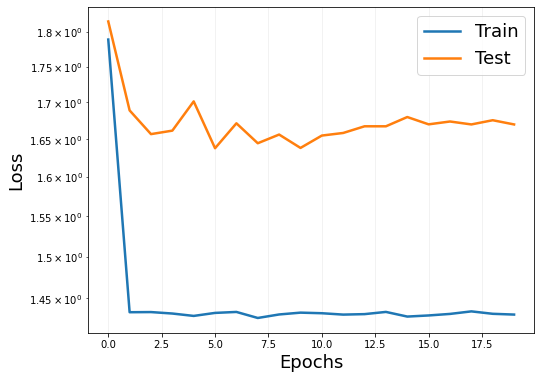

In [20]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [21]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        
        temp_input = x[:,13]
        proj = model(x)
        pred = implicit_diffusion(proj, temp_input, input_mean, input_std,
                                 output_mean, output_std)        
        pred = pred.to(dtype=torch.float32)
        
        
        y = y * std + mean
        pred = pred * std + mean
        
        #red = torch.squeeze(pred)
        
        #rint(pred.shape)
        
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    
    rmse_temp = rmse(y_[:,0], pred_)
    
    l2_error_temp = l2_error(y_[:,0], pred_)
    return rmse_temp, l2_error_temp

In [22]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 4.4851874869722925
L2 Error  of Temp: 0.3088981494221723


In [23]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 4.4224851352218675
L2 Error  of Temp: 0.3454865346515398


# Saving Model

In [24]:
PATH = f"./saved_models/heat_diffusion_model_time.pth"
torch.save(model.state_dict(), PATH)

In [25]:
output_mean

array([11.34604205])